In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import scipy
from scipy.stats import logistic
from scipy.special import expit
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, precision_score, 
                             roc_auc_score, roc_curve)

# Quiet setting warnings
pd.options.mode.chained_assignment = None


# Background

In [2]:
# Set wkdir
WORK_DIR = os.getcwd()

In [3]:
# 50 sample dataset
data50_df = pd.read_excel(f'{WORK_DIR}/CardiacHypertrophyData_50Samples.xlsx')
print(data50_df.shape)
data50_df.head(5)

(50, 7)


,Age,Sex,Racial group,Ejection fraction,Heart rate (bpm),Systolic blood pressure,Pathologic?
0,59.053851,Male,Asian,0.625929,71.025200,98.960236,0
1,56.291312,Male,White,0.632001,51.666039,112.938934,0
2,66.216488,Male,White,0.601147,105.635574,98.363388,1
3,45.684119,Female,Black or African American,0.546039,96.767563,104.544754,0
4,69.492794,Female,White,0.677071,86.660133,129.907806,1


In [4]:
# 200 sample dataset
data200_df = pd.read_excel(f'{WORK_DIR}/CardiacHypertrophyData_200Samples.xlsx')
print(data200_df.shape)
data200_df.head(5)

(200, 7)


,Age,Sex,Racial group,Ejection fraction,Heart rate (bpm),Systolic blood pressure,Pathologic?
0,58.706430,Male,White,0.581767,109.255325,120.983421,0
1,59.108509,Female,Hispanic or Latino,0.706900,104.015976,111.671471,0
2,48.160970,Male,White,0.644444,101.856407,95.749603,0
3,57.649055,Female,Black or African American,0.572398,69.098885,103.728004,0
4,58.849777,Male,White,0.616101,72.875412,104.763771,0


# Generic Functions

In [5]:
def X_y_split(df, target, to_numpy: bool):
    '''
    Function to split df into features (X) and target (y)
    to_numpy boolean flag can be used to convert X and y outputs to numpy arrays
    '''
    X = df.loc[:, df.columns != target]
    y = df.loc[:, target]
    if to_numpy:
        return X.to_numpy(), y.to_numpy()
    else:
        return X, y
    

# EDA

## Missing Data
No missing data in this dataset

In [6]:
# View missing data for 50 sample set
print('50 Sample Missing Data:')
print(data50_df.isnull().sum())
print('\n')

# View missing data for 200 sample set
print('200 Sample Missing Data:')
print(data200_df.isnull().sum())

50 Sample Missing Data:
Age                        0
Sex                        0
Racial group               0
Ejection fraction          0
Heart rate (bpm)           0
Systolic blood pressure    0
Pathologic?                0
dtype: int64


200 Sample Missing Data:
Age                        0
Sex                        0
Racial group               0
Ejection fraction          0
Heart rate (bpm)           0
Systolic blood pressure    0
Pathologic?                0
dtype: int64


## Visualizing Target & Feature Balance/Distributions

In [7]:
def num_feature_dist_plot(df, n_col, bins, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each numeric feature in a data frame
    '''

    # Extract features to plot - only numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    
    # Set figure space
    plt.style.use('seaborn')
    n_row = int(np.ceil(len(numeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(numeric_features):
        
        # Plot
        sns.histplot(data=df, x=feature, ax=plots[i], color='tab:blue', bins=bins)
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_xlabel('')
        
    plt.show()
        

def cat_feature_count_plot(df, n_col, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each categorical feature in a data frame
    '''

    # Extract features to plot - only non-numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    nonnumeric_features = [feature for feature in df.columns if feature not in numeric_features]
    print(nonnumeric_features)
    
    # Set figure space
    plt.style.use('seaborn')
    n_row = int(np.ceil(len(nonnumeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(nonnumeric_features):
        
        # Set count df for plot
        labels = list(set(df[feature]))
        counts = [list(df[feature]).count(c) for c in labels]
        plot_df = pd.DataFrame({'labels': [label if label is not np.nan else "Missing" for label in labels], 
                                'counts': counts})
        
        
        # Plot
        sns.barplot(data=plot_df, y="labels", x="counts", ax=plots[i], color="tab:blue")
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_ylabel('')
        
    plt.show()
    
    

In [8]:
# Split data for visualizations
X_50, y_50 = X_y_split(df=data50_df, target='Pathologic?', to_numpy=False)
X_200, y_200 = X_y_split(df=data200_df, target='Pathologic?', to_numpy=False)

## Numeric Features

### 50 Sample Data Set

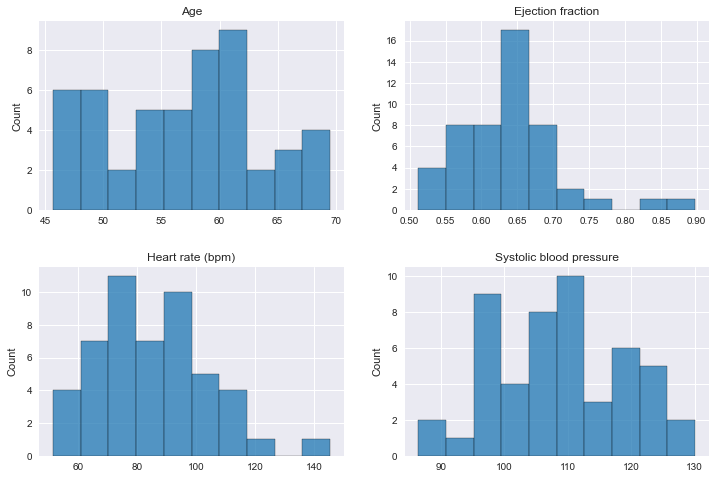

In [9]:
num_feature_dist_plot(df=X_50, n_col=2, fig_width=12, fig_height=8, bins=10, hspace=0.3, wspace=0.2)

### 200 Sample Data Set

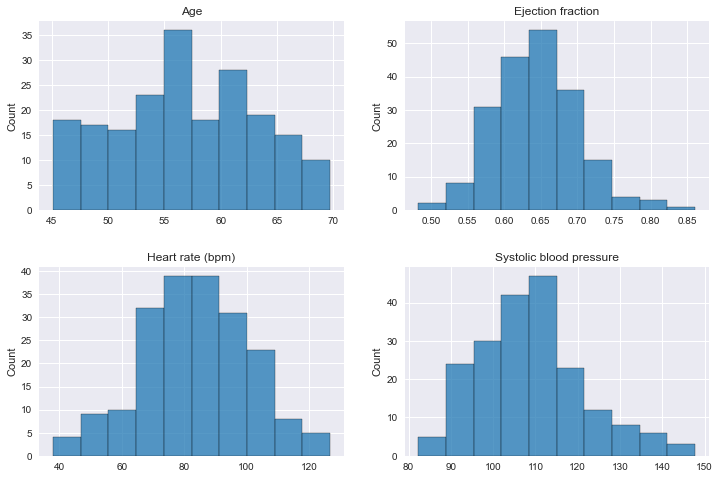

In [10]:
num_feature_dist_plot(df=X_200, n_col=2, fig_width=12, fig_height=8, bins=10, hspace=0.3, wspace=0.2)

## Categorical Features

### 50 Sample Data Set

['Sex', 'Racial group']


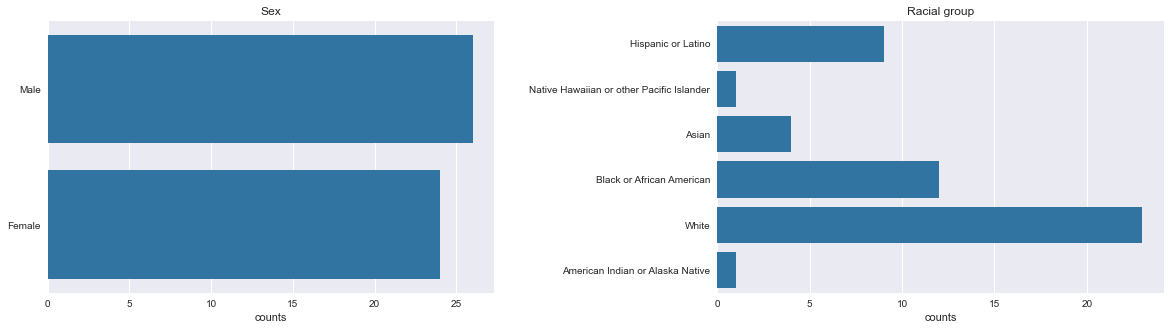

In [11]:
cat_feature_count_plot(df=X_50, n_col=2, fig_width=20, fig_height=5, hspace=0, wspace=0.5)

### 200 Sample Data Set

['Sex', 'Racial group']


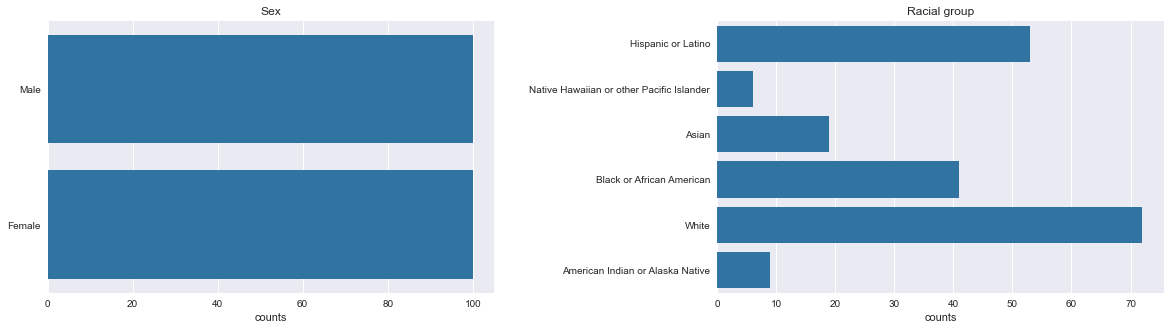

In [12]:
cat_feature_count_plot(df=X_200, n_col=2, fig_width=20, fig_height=5, hspace=0, wspace=0.5)

## Target Variable

80% of observations have target values of 0 ("not pathologic"). This 80% mark should be used as a benchmark for assessing model performance since 80% accuracy would be achieved if a model guesses the same class ("not pathologic") every time.

### 50 Sample Data Set

Text(0, 0.5, '')

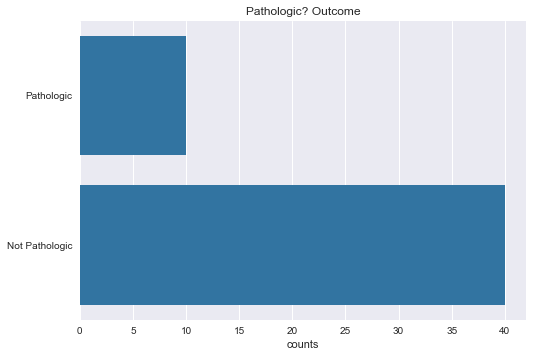

In [13]:
# Encode outcome var
yVis = y_50.copy()
yVis = yVis.map({0: 'Not Pathologic', 1: 'Pathologic'})

# Set count df for plot
labels = list(set(yVis))
counts = [list(yVis).count(c) for c in labels]
plot_df = pd.DataFrame({'labels': [label if label is not np.nan else "Missing" for label in labels], 
                        'counts': counts})    
        
# Plot
fig, ax = plt.subplots()
sns.barplot(data=plot_df, y="labels", x="counts", color="tab:blue")
ax.set_title('Pathologic? Outcome', fontsize=12)
ax.set_ylabel('')

### 200 Sample Dataset

Text(0, 0.5, '')

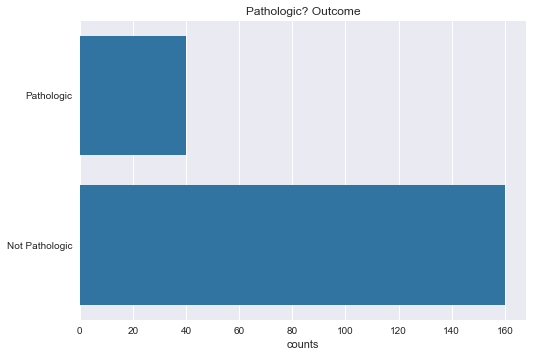

In [14]:
# Encode outcome var
yVis = y_200.copy()
yVis = yVis.map({0: 'Not Pathologic', 1: 'Pathologic'})

# Set count df for plot
labels = list(set(yVis))
counts = [list(yVis).count(c) for c in labels]
plot_df = pd.DataFrame({'labels': [label if label is not np.nan else "Missing" for label in labels], 
                        'counts': counts})    
        
# Plot
fig, ax = plt.subplots()
sns.barplot(data=plot_df, y="labels", x="counts", color="tab:blue")
ax.set_title('Pathologic? Outcome', fontsize=12)
ax.set_ylabel('')

# Data Pre-Processing

## Categorical Variable Encoding

In [15]:
def encodeCategories(X, drop: bool):
    '''
    Function to encode categorical features
    Features with two categories will be encoded as binary
    Features with more than two categories will be one-hot-encoded
    '''
    # Copy df 
    df = X.copy()
    categorialColumnNames_list = df.select_dtypes(include=['object']).columns.values.tolist()
    featureCategoryCount_dict = {feature: len(set(df[feature])) for feature in categorialColumnNames_list}
    
    # Display message
    print('Encoding categorical features...\n')
    
    # Encode feature based on number of categories
    for feature, categoryCount in featureCategoryCount_dict.items():

        # Convert binary feature to binary 0, 1
        if categoryCount == 2:

            # Encode column
            feat0, feat1 = tuple(set(df[feature]))
            df[feature] = df[feature].map({feat0: 0, feat1: 1})

            # Display which category is encoded 0 and 1
            print(feature + ' encoded as binary')
            print(f'   0: {feat0}')
            print(f'   1: {feat1}\n')

        # One-hot-encode feature with more than 2 categories
        elif categoryCount > 2:

            # Code adapted from Antonio Perez, PhD
            # Encode column
            if drop:
                encoder = OneHotEncoder(handle_unknown='error', drop='first', sparse=False)
            else:
                encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
            encoder.fit(df[feature].to_numpy().reshape(-1, 1))
            encodedData = encoder.transform(df[feature].to_numpy().reshape(-1, 1))

            # Copy to data frame
            for i in range(encodedData.shape[1]):
                if type(encoder.categories_[0][i]) == str:
                    df[f'{feature}_{encoder.categories_[0][i]}'] = encodedData[:, i]

            # Drop original column
            df.pop(feature)

            # Display message
            print(f'{feature} one-hot-encoded\n')

        # Safe gaurd against features with only one category
        else:
            pass
        
    return df



# Logistic Regression & Cross-Validation

**Notes on Stratified K-Fold Cross Validation**  
Stratified K-Fold provides train/test indices to split data into train/test sets. Folds are made by preserving the percentage of samples for each class. The number of folds (k) made is controlled by the n_splits parameter. Increasing k decreases the test set size, and vice versa.

## Functions for Implementation

In [16]:
def flatten_list(list_of_lists):
    '''
    Function to flatten a list of lists into one list
    e.g. [[1, 0, 0], [0, 0, 1]] -> [1, 0, 0, 0, 0, 1]
    Source: https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
    '''
    return [item for sublist in list_of_lists for item in sublist]


def kFold_logReg_classification(X, y, k_fold: int):
    '''
    Function to implement k-fold cross-validation for Logistic Regression Classification
    
    Inputs: 
        X: Features (numpy matrix)
        y: Target (numpy array)
        k_fold (number of splits for stratified k-fold cross-validator)
        
    Outputs:
    *NOTE: All outputs are concatenated lists that contain results from all folds*
        y_true: True values of targets
        y_pred: Predicted values of targets (as determined by trained Logistic Regression model)
        y_score: Target scores (probability estimates of the positive class)
    '''
    
    # Initialize stratified k-fold cross-validator
    kfold = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=1)
    
    # Store train/test split sizes for each fold size
    fold_info = ''
    
    # Initialize list to store results
    y_true_allFolds = []
    y_pred_allFolds = []
    y_score_allFolds = []

    # For each fold (#folds = k): train, test, evaluate performance
    for train_index, test_index in kfold.split(X, y):

        # Display train/test split size
        fold_info = f'n_kFold: {k_fold}, n_Train: {len(train_index)}, n_Test: {len(test_index)}\n'

        # Split data into train/test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Standardize features - train scalar on test set to prevent test set leak
        scaler = StandardScaler()               # Initialize scaler
        X_train = scaler.fit_transform(X_train) # Train scalar on training set and tranform training set
        X_test = scaler.transform(X_test)       # Transform test set using fit from training set

        # Train logistic regression model
        logisticReg = LogisticRegression()
        logisticReg.fit(X_train, y_train)

        # Make predictions on test set
        y_pred = logisticReg.predict(X_test)
        y_score = logisticReg.predict_proba(X_test)[:,1]

        # Append results from all folds into collective lists
        y_true_allFolds.append(list(y_test))
        y_pred_allFolds.append(list(y_pred))
        y_score_allFolds.append(list(y_score))
    
    # Flatten lists to evaluate all folds collectively
    y_true_allFoldsFlat = np.array(flatten_list(y_true_allFolds))
    y_pred_allFoldsFlat = np.array(flatten_list(y_pred_allFolds))
    y_score_allFoldsFlat = np.array(flatten_list(y_score_allFolds))
    
    # Provide fold information (n_kFold, n_Train, n_Test)
    print('Stratified k-fold cross-validation information')
    print(fold_info + '\n')
    
    # Return lists
    return y_true_allFoldsFlat, y_pred_allFoldsFlat, y_score_allFoldsFlat


def logReg_performance_eval(y_true, y_pred, y_score, roc_label):
    '''
    Function to evaluate performance of Logistic Regression (or any binary) classifier
    
    Inputs:
        y_true: True values of targets
        y_pred: Predicted values of targets (as determined by trained model)
        y_score: Target scores (probability estimates of the positive class)
        
    Outputs:
        Classification report
        ROC curve with AUC score reported
    '''
    
    # Performance evaluation
    print(classification_report(y_true, y_pred))

    # ROC, AUC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)    
    
    # ROC Curve
    #plt.figure()
    plt.plot(fpr, tpr, marker='.', label=f'{roc_label} (AUC = {round(auc, 3)})')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    #plt.show()
    
    

## 50 Sample Dataset

Encoding categorical features...

Sex encoded as binary
   0: Male
   1: Female

Racial group one-hot-encoded

-----------------------------------------------

-----------------------------------------------------------

Stratified k-fold cross-validation information
n_kFold: 2, n_Train: 25, n_Test: 25


              precision    recall  f1-score   support

           0       0.87      1.00      0.93        40
           1       1.00      0.40      0.57        10

    accuracy                           0.88        50
   macro avg       0.93      0.70      0.75        50
weighted avg       0.90      0.88      0.86        50

------------------------------------------------------------

Stratified k-fold cross-validation information
n_kFold: 5, n_Train: 40, n_Test: 10


              precision    recall  f1-score   support

           0       0.86      0.95      0.90        40
           1       0.67      0.40      0.50        10

    accuracy                           0.84        50
  

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=25.
  warnings.warn(("The least populated class in y has only %d"


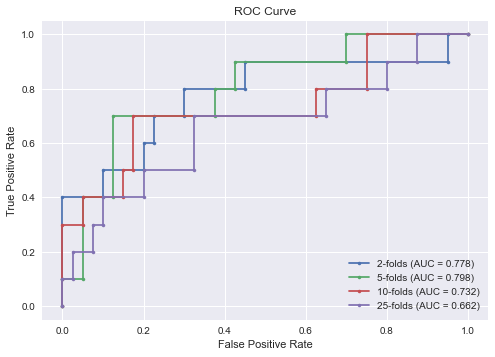

In [17]:
# Split into X, y and encode categorical features
X, y = X_y_split(df=data50_df, target='Pathologic?', to_numpy=False)
X = encodeCategories(X, drop=False)
print(f'-----------------------------------------------\n')

# Store accuracy, precision and AUC for each fold size
fold_metrics = {
    'Fold Size': [],
    'Test Size': [],
    'Train/Test Split': [],
    'Accuracy': [],
    'ROC-AUC': [],
}

print('-----------------------------------------------------------\n')

# Implement k-fold cross-validation with logistic regression classifier for multiple sizes of k
fold_size = [2, 5, 10, 25]
for k in fold_size:
    
    # Stratified k-fold cross-validation of Logistic Regression model
    y_true, y_pred, y_score = kFold_logReg_classification(X=X.to_numpy(), y=y.to_numpy(), k_fold=k)
    
    # Evaluate performance with classification report and ROC
    logReg_performance_eval(y_true=y_true, y_pred=y_pred, y_score=y_score, roc_label=f'{k}-folds')
    print(f'------------------------------------------------------------\n')
    
    # Store metrics for each fold size
    test_size = int(len(y)/k)
    train_size = int(len(y)-test_size)
    fold_metrics['Fold Size'].append(k)
    fold_metrics['Test Size'].append(test_size)
    fold_metrics['Train/Test Split'].append(f'{int(100*train_size/len(y))}/{100-int(100*train_size/len(y))}')
    fold_metrics['Accuracy'].append(round(accuracy_score(y_true, y_pred), 3))
    fold_metrics['ROC-AUC'].append(round(roc_auc_score(y_true, y_score), 3))


### Summary Table

In [18]:
pd.DataFrame(fold_metrics)

,Fold Size,Test Size,Train/Test Split,Accuracy,ROC-AUC
0,2,25,50/50,0.88,0.778
1,5,10,80/20,0.84,0.798
2,10,5,90/10,0.82,0.732
3,25,2,96/4,0.80,0.662


Text(0, 0.5, 'ROC-AUC')

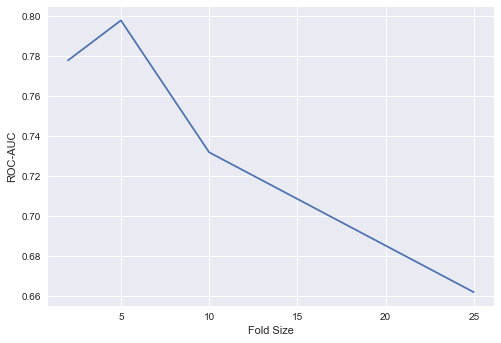

In [19]:
# Plot ROC-AUC vs fold size
plt.figure()
plt.plot(fold_metrics['Fold Size'], fold_metrics['ROC-AUC'])
plt.xlabel('Fold Size')
plt.ylabel('ROC-AUC')

### Discussion

Fold size ($k$) is inversely proportional to test size. As $k$ increases (and test size decreases), training set size increases. In general, smaller training sets (and smaller sizes of $k$) should increase the likelihood of overfitting, 

The summary table above shows the effect that fold-size has on classifier accuracy and ROC-AUC when fitting this data with a logistic regression model. Accuracy tends to increase with decreased fold-size (and smaller training set sizes), which is likely a misleading performance metric due to class imbalance. ROC-AUC is maximized at a fold-size of 5, which corresponds to an 80/20 train/test split, and is relatively worsened at the fold-size extremes ($k$=2, $k$=25). Precision scores wrt calling 1 decreses as k increases (and is 100% for the $k$=2 model). In other words, when $k$ is small (and the training set is small), the logistic regression model is likely guessing 1 way more conservatively. That is, it's not guessing 1 a lot - but when it does it is correct. Increasing $k$ and the training set size results in the model guessing 1 much more often, getting that 1 call incorrect more often, and hence having diminished precision and accuracy. We likely want incorporate a balance when it comes to this, which is why we are observing maximized ROC-AUC at $k$=5.

## 200 Sample Dataset

Encoding categorical features...

Sex encoded as binary
   0: Male
   1: Female

Racial group one-hot-encoded

-----------------------------------------------

Stratified k-fold cross-validation information
n_kFold: 2, n_Train: 100, n_Test: 100


              precision    recall  f1-score   support

           0       0.85      0.96      0.90       160
           1       0.65      0.33      0.43        40

    accuracy                           0.83       200
   macro avg       0.75      0.64      0.67       200
weighted avg       0.81      0.83      0.81       200

------------------------------------------------------------

Stratified k-fold cross-validation information
n_kFold: 5, n_Train: 160, n_Test: 40


              precision    recall  f1-score   support

           0       0.85      0.94      0.89       160
           1       0.57      0.33      0.41        40

    accuracy                           0.81       200
   macro avg       0.71      0.63      0.65       200
weight

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 40 members, which is less than n_splits=100.
  warnings.warn(("The least populated class in y has only %d"


Stratified k-fold cross-validation information
n_kFold: 100, n_Train: 198, n_Test: 2


              precision    recall  f1-score   support

           0       0.85      0.93      0.89       160
           1       0.56      0.35      0.43        40

    accuracy                           0.81       200
   macro avg       0.71      0.64      0.66       200
weighted avg       0.79      0.81      0.80       200

------------------------------------------------------------



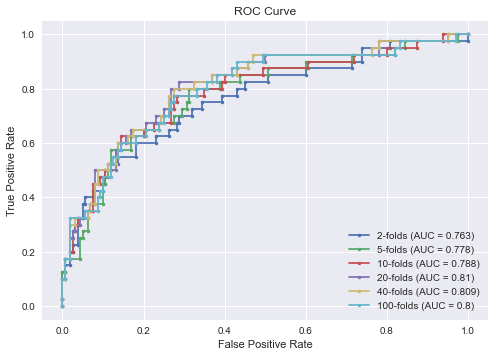

In [20]:
# Split into X, y and encode categorical features
X, y = X_y_split(df=data200_df, target='Pathologic?', to_numpy=False)
X = encodeCategories(X, drop=False)
print(f'-----------------------------------------------\n')

# Store accuracy, precision and AUC for each fold size
fold_metrics = {
    'Fold Size': [],
    'Test Size': [],
    'Train/Test Split': [],
    'Accuracy': [],
    'ROC-AUC': [],
}

# Implement k-fold cross-validation with logistic regression classifier for multiple sizes of k
fold_size = [2, 5, 10, 20, 40, 100]
for k in fold_size:
    
    # Stratified k-fold cross-validation of Logistic Regression model
    y_true, y_pred, y_score = kFold_logReg_classification(X=X.to_numpy(), y=y.to_numpy(), k_fold=k)
    
    # Evaluate performance with classification report and ROC
    test_size = int(len(y)/k)
    train_size = int(len(y)-test_size)
    logReg_performance_eval(y_true=y_true, y_pred=y_pred, y_score=y_score, roc_label=f'{k}-folds')
    print(f'------------------------------------------------------------\n')
    
    # Store metrics for each fold size
    fold_metrics['Fold Size'].append(k)
    fold_metrics['Test Size'].append(test_size)
    fold_metrics['Train/Test Split'].append(f'{int(100*train_size/len(y))}/{100-int(100*train_size/len(y))}')
    fold_metrics['Accuracy'].append(round(accuracy_score(y_true, y_pred), 3))
    fold_metrics['ROC-AUC'].append(round(roc_auc_score(y_true, y_score), 3))


### Summary Table

In [21]:
pd.DataFrame(fold_metrics)

,Fold Size,Test Size,Train/Test Split,Accuracy,ROC-AUC
0,2,100,50/50,0.830,0.763
1,5,40,80/20,0.815,0.778
2,10,20,90/10,0.815,0.788
3,20,10,95/5,0.815,0.810
4,40,5,97/3,0.820,0.809
5,100,2,99/1,0.815,0.800


Text(0, 0.5, 'ROC-AUC')

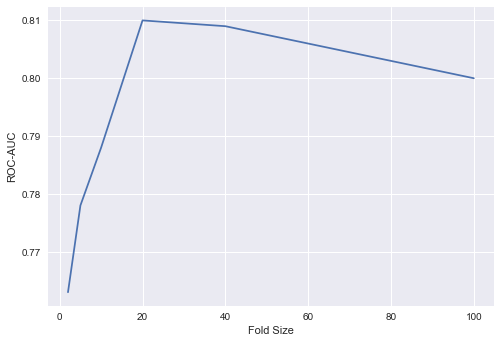

In [22]:
# Plot ROC-AUC vs fold size
plt.figure()
plt.plot(fold_metrics['Fold Size'], fold_metrics['ROC-AUC'])
plt.xlabel('Fold Size')
plt.ylabel('ROC-AUC')

### Discussion

We see somewhat similar trends here. (1) Accuracy is maximized when fold size is smallest, and (2) ROC-AUC maximization is not linearly related to fold-size, training set size, or test set size. Again, the ROC-AUC curve tells us that the best trade off between between true- and false-positive rate exists somewhere in the middle of the extreme fold sizes. For this particular case, optimal fold-size (in terms of maximizing ROC-AUC) is 20, which corresponds to a 95/5 train/test split. It is important to note, however, that the range of AUC values observed is much tighter (ie. there aren't as extreme of drop-offs in ROC-AUC at the extreme fold sizes). This indicates that increasing $n$ makes modeling results less sensitive to the value of $k$ during $k$-fold cross-validation.

# Final Model Ready for Deployment

## Combine all data

In [23]:
# For the final model we'll use all avaialable data
data_full_df = pd.concat([data50_df, data200_df])
print(data_full_df.shape)
data_full_df.head(5)

(250, 7)


,Age,Sex,Racial group,Ejection fraction,Heart rate (bpm),Systolic blood pressure,Pathologic?
0,59.053851,Male,Asian,0.625929,71.025200,98.960236,0
1,56.291312,Male,White,0.632001,51.666039,112.938934,0
2,66.216488,Male,White,0.601147,105.635574,98.363388,1
3,45.684119,Female,Black or African American,0.546039,96.767563,104.544754,0
4,69.492794,Female,White,0.677071,86.660133,129.907806,1


## Fit Model & Assess Performance

Encoding categorical features...

Sex encoded as binary
   0: Male
   1: Female

Racial group one-hot-encoded

-----------------------------------------------------------

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       200
           1       0.77      0.40      0.53        50

    accuracy                           0.86       250
   macro avg       0.82      0.69      0.72       250
weighted avg       0.85      0.86      0.84       250



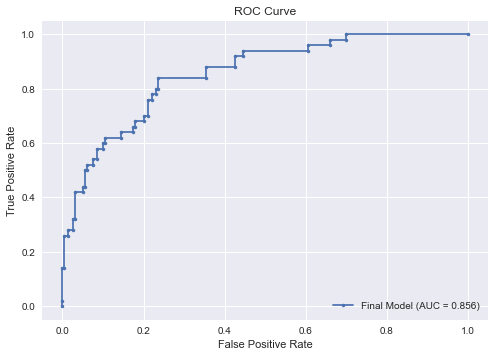

In [24]:
# Split into X, y and encode categorical features
X, y = X_y_split(df=data_full_df, target='Pathologic?', to_numpy=False)
cols_to_encode = ['Sex', 'Racial group']
X_encoded = encodeCategories(X[cols_to_encode], drop=False)
encoded_cols = list(X_encoded.columns)
print('-----------------------------------------------------------\n')

# Initialize scaler, fit and tranform features
scaled_cols = ['Age', 'Ejection fraction', 'Heart rate (bpm)', 'Systolic blood pressure']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[scaled_cols])

# Re-join encoded and scaled features
X_ready = np.concatenate([X_encoded, X_scaled], axis=1)
feature_order = encoded_cols + scaled_cols

# Train logistic regression model on all data
logisticReg = LogisticRegression()
logisticReg.fit(X_ready, y.to_numpy())

# Make predictions using set of features used to train data
y_pred = logisticReg.predict(X_ready)
y_score = logisticReg.predict_proba(X_ready)[:,1]

# Performance evaluation
logReg_performance_eval(y_true=y.to_numpy(), y_pred=y_pred, y_score=y_score, roc_label='Final Model')

## Visualize Relationship Between Features & Predictions 

In [25]:
# Merge categorical and standardized features for visualizations
col_names = cols_to_encode + scaled_cols
model_results_df = pd.DataFrame(np.concatenate([X[cols_to_encode], X_scaled], axis=1), columns=col_names)
model_results_df['Age'] = model_results_df['Age'].astype(float)

# Merge model predictions into df
model_results_df['True Class'] = y.to_numpy()
model_results_df['Predicted Class'] = y_pred
model_results_df['Predicted Prob of Class=1'] = y_score
model_results_df['logit(Prob of Class=1)'] = np.log(y_score/(1-y_score))
model_results_df.head(5)

,Sex,Racial group,Age,Ejection fraction,Heart rate (bpm),Systolic blood pressure,True Class,Predicted Class,Predicted Prob of Class=1,logit(Prob of Class=1)
0,Male,Asian,0.330090,-0.300391,-0.767104,-0.82058,0,0,0.045689,-3.039122
1,Male,White,-0.104886,-0.199628,-1.886496,0.341522,0,0,0.074787,-2.515374
2,Male,White,1.457885,-0.711693,1.234149,-0.870198,1,0,0.119513,-1.997053
3,Female,Black or African American,-1.775044,-1.626315,0.72138,-0.356318,0,0,0.014286,-4.234083
4,Female,White,1.973756,0.548393,0.136945,1.752209,1,1,0.684804,0.775938


### Numeric Features vs Predictions

Plots below show the probability of predicting 1 (pathologic) vs each numerical feature. All data points above y=0.50 indicate instances in which the classifier predicted 1, while all data points below y=0.50 indicate instances in which the classifier predicted 0. It appears that the classifier predicted 1 across all ages, which suggests that no strong or obvious relationship exists between age and predicted outcome. All other numeric features appear to have a sigmoidal relationship with the predicted probabilities. I therefore took the logit of the predicted probabilities and re-plotted the data (plots on the right-hand side). The logit-transformed plots now show a linear relationship between the non-age numeric features and the logit of the probability of class being 1. Nice!

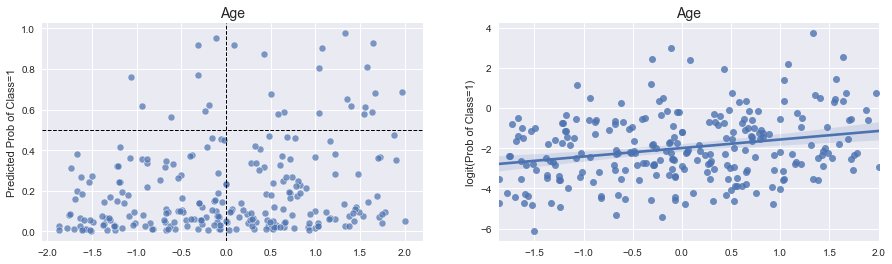

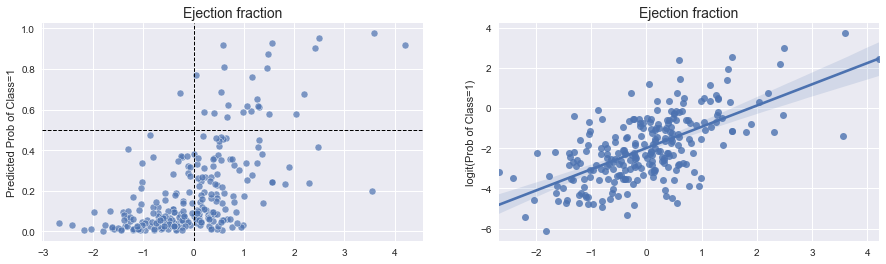

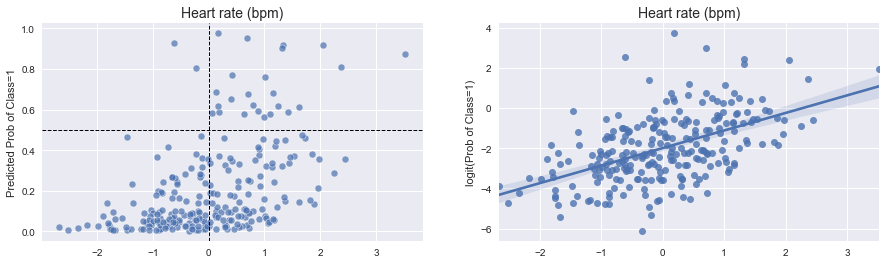

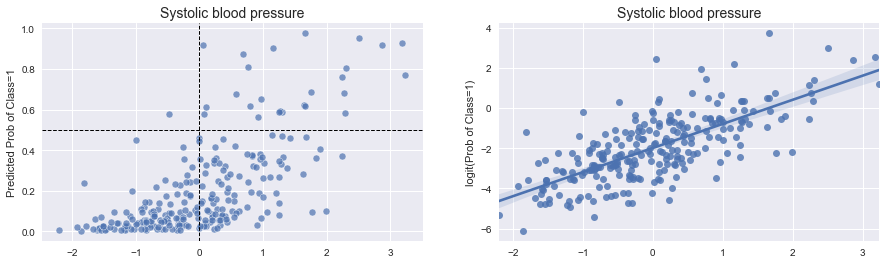

In [26]:
# Plot features vs predictions
features_to_plot = ['Age', 'Ejection fraction', 'Heart rate (bpm)', 'Systolic blood pressure']
for feature in features_to_plot:
    model_results_df[feature] = model_results_df[feature].astype(float) # Ensure feature is float
    
    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    plots = [ax for ax in axs]
    
    # Prob of 1 vs feature
    sns.scatterplot(data=model_results_df, x=feature, y='Predicted Prob of Class=1', ax=plots[0], alpha=0.7)
    plots[0].axhline(0.5, color='black', linestyle ="--", lw=1)
    plots[0].axvline(0, color='black', linestyle ="--", lw=1)
    plots[0].set_title(feature, size=14)
    plots[0].set_xlabel('')
    
    # logit(Prob of 1) vs feature
    sns.regplot(data=model_results_df, x=feature, y='logit(Prob of Class=1)', ax=plots[1])
    plots[1].set_title(feature, size=14)
    plots[1].set_xlabel('')

### Categorical Features vs Predictions

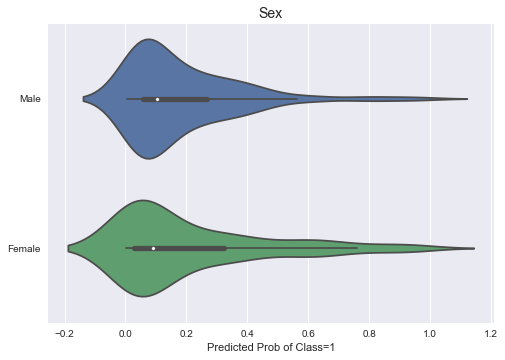

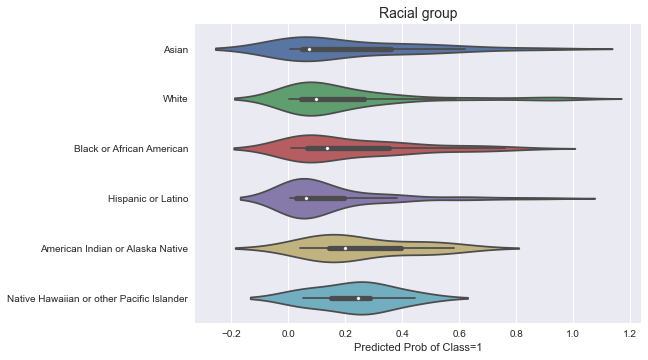

In [27]:
# Plot features vs predictions
features_to_plot = ['Sex', 'Racial group']
for feature in features_to_plot:
    #model_results_df[feature] = model_results_df[feature].astype('category') # Ensure feature is category
    plt.figure()
    sns.violinplot(data=model_results_df, x='Predicted Prob of Class=1', y=feature)
    plt.title(feature, size=14)
    plt.ylabel('')

# Questions
1. What happens when we standardize or normalize one-hot-encoded data? Do we need to do these separately and then merge?  
2. When is it appropriate to drop/leave one of the columns when one-hot-encoding?